# Escenario 1: MDP Básico para Gestión de Data Center

## Descripción General

Este notebook implementa un **Proceso de Decisión de Markov (MDP)** para la gestión inteligente de un centro de datos con múltiples servidores. El sistema debe tomar decisiones óptimas sobre cómo asignar solicitudes entrantes, realizar mantenimiento preventivo y gestionar recursos bajo condiciones de incertidumbre.

### Características del Problema

- **5 servidores** con estados multidimensionales (carga, temperatura, estado operativo)
- **3 tipos de solicitudes** con diferentes prioridades (alta 20%, media 50%, baja 30%)
- **12 acciones posibles**: asignar a servidores, rechazar, mantenimiento, balanceo
- **Transiciones estocásticas**: fallos dependientes de temperatura (40-60% según condiciones)
- **Recompensas complejas**: bonos por prioridad, penalizaciones por rechazo/fallo

### Algoritmos Implementados

1. **Value Iteration**: Convergencia por aproximación de valores óptimos (~15-30 iteraciones)
2. **Policy Iteration**: Convergencia por evaluación y mejora de políticas (~6-10 iteraciones)
3. **Greedy Baseline**: Política simple para comparación de resultados

### Escenario de Evaluación

El sistema opera bajo condiciones de alta presión:
- Tasa de llegada de solicitudes: **0.90 req/step** (alta presión)
- Probabilidad de fallo crítico: **40-60%** según temperatura y carga
- Simulación extendida: **3000 pasos** para análisis robusto
- Resultados esperados: **~99.7% throughput** con diferencias sutiles entre políticas

Este escenario permite observar diferencias reales entre políticas aprendidas (VI/PI) y estrategias simples (Greedy) bajo condiciones de estrés, validando que los algoritmos de programación dinámica aprenden estrategias superiores.

## 1. Importar Librerías y Configuración Inicial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict
from itertools import product

# Configuración de reproducibilidad
SEED = 42
np.random.seed(SEED)

# Configuración del escenario
N_SERVERS = 5
N_REQUEST_TYPES = 3  # Alta, Media, Baja prioridad
GAMMA = 0.9  # Factor de descuento
THETA = 1e-4  # Umbral de convergencia

print(f"✓ Escenario 1 configurado: {N_SERVERS} servidores, {N_REQUEST_TYPES} tipos de solicitudes")

✓ Escenario 1 configurado: 5 servidores, 3 tipos de solicitudes


## 2. Definición del Modelo MDP

### 2.1 Estados (S)

Cada servidor tiene:
- **Carga**: {0=libre, 1=media, 2=alta}
- **Temperatura**: {0=normal, 1=alta, 2=crítica}
- **Estado operativo**: {0=activo, 1=mantenimiento, 2=fallado}

El estado global es la tupla de estados de todos los servidores.

In [3]:
# Constantes de estado
LOAD_LEVELS = 3  # libre, media, alta
TEMP_LEVELS = 3  # normal, alta, crítica
OP_STATES = 3    # activo, mantenimiento, fallado

# Codificación de estado por servidor: (carga, temperatura, estado_operativo)
# Estado = índice único calculado como: carga + temperatura*3 + operativo*9
N_STATES_PER_SERVER = LOAD_LEVELS * TEMP_LEVELS * OP_STATES  # 27 estados por servidor

def encode_server_state(load, temp, operative):
    """Codifica el estado de un servidor en un índice único."""
    return load + temp * LOAD_LEVELS + operative * (LOAD_LEVELS * TEMP_LEVELS)

def decode_server_state(state_idx):
    """Decodifica un índice de estado a (carga, temperatura, operativo)."""
    operative = state_idx // (LOAD_LEVELS * TEMP_LEVELS)
    remainder = state_idx % (LOAD_LEVELS * TEMP_LEVELS)
    temp = remainder // LOAD_LEVELS
    load = remainder % LOAD_LEVELS
    return load, temp, operative

# Generar todos los estados posibles de un servidor
all_server_states = list(range(N_STATES_PER_SERVER))

print(f"✓ Estados por servidor: {N_STATES_PER_SERVER}")
print(f"✓ Ejemplo estado 0: {decode_server_state(0)}")
print(f"✓ Ejemplo estado 26: {decode_server_state(26)}")

✓ Estados por servidor: 27
✓ Ejemplo estado 0: (0, 0, 0)
✓ Ejemplo estado 26: (2, 2, 2)


### 2.2 Acciones (A)

Acciones disponibles:
- **0-4**: Asignar solicitud al servidor 0-4
- **5**: Rechazar solicitud
- **6-10**: Iniciar mantenimiento preventivo en servidor 0-4
- **11**: Balancear carga entre servidores

In [4]:
# Definición de acciones
ACTION_ASSIGN_START = 0
ACTION_ASSIGN_END = N_SERVERS - 1
ACTION_REJECT = N_SERVERS
ACTION_MAINTENANCE_START = N_SERVERS + 1
ACTION_MAINTENANCE_END = 2 * N_SERVERS
ACTION_BALANCE = 2 * N_SERVERS + 1

N_ACTIONS = 2 * N_SERVERS + 2

def get_action_name(action):
    """Retorna el nombre descriptivo de una acción."""
    if ACTION_ASSIGN_START <= action <= ACTION_ASSIGN_END:
        return f"Asignar a servidor {action}"
    elif action == ACTION_REJECT:
        return "Rechazar solicitud"
    elif ACTION_MAINTENANCE_START <= action <= ACTION_MAINTENANCE_END:
        srv = action - ACTION_MAINTENANCE_START
        return f"Mantenimiento servidor {srv}"
    elif action == ACTION_BALANCE:
        return "Balancear carga"
    return "Acción desconocida"

print(f"✓ Total de acciones: {N_ACTIONS}")
print(f"✓ Acciones de asignación: {ACTION_ASSIGN_START}-{ACTION_ASSIGN_END}")
print(f"✓ Acción de rechazo: {ACTION_REJECT}")
print(f"✓ Acciones de mantenimiento: {ACTION_MAINTENANCE_START}-{ACTION_MAINTENANCE_END}")
print(f"✓ Acción de balanceo: {ACTION_BALANCE}")

✓ Total de acciones: 12
✓ Acciones de asignación: 0-4
✓ Acción de rechazo: 5
✓ Acciones de mantenimiento: 6-10
✓ Acción de balanceo: 11


### 2.3 Función de Recompensa R(s,a,s')

La recompensa considera múltiples factores:
- **+10**: Servicio completado exitosamente
- **-3**: Costo por uso de recursos (proporcional a carga)
- **-5**: Penalización por rechazar solicitud
- **-20**: Penalización por fallo del servidor
- **-8**: Costo de mantenimiento preventivo
- **+5**: Bonus por balanceo efectivo de carga

In [5]:
def compute_reward(server_states_before, action, server_states_after, request_type=1):
    """
    Calcula la recompensa R(s, a, s') según el modelo del README.
    
    Args:
        server_states_before: Lista de estados de servidores antes de la acción
        action: Acción tomada
        server_states_after: Lista de estados de servidores después de la acción
        request_type: Tipo de solicitud (0=alta, 1=media, 2=baja prioridad)
    
    Returns:
        reward: Recompensa total
    """
    reward = 0.0
    
    # Decodificar estados
    states_before = [decode_server_state(s) for s in server_states_before]
    states_after = [decode_server_state(s) for s in server_states_after]
    
    # Acción de asignación a servidor
    if ACTION_ASSIGN_START <= action <= ACTION_ASSIGN_END:
        server_id = action
        load_before, temp_before, op_before = states_before[server_id]
        load_after, temp_after, op_after = states_after[server_id]
        
        # Verificar si la asignación fue exitosa
        if op_before == 0:  # servidor activo
            if op_after == 2:  # servidor falló durante la operación
                reward = -20  # penalización por fallo
            else:
                # Servicio completado exitosamente
                base_reward = 10
                priority_bonus = [3, 0, -2][request_type]  # bonus por prioridad
                reward = base_reward + priority_bonus
                
                # Costo por uso de recursos (proporcional a carga)
                resource_cost = 1 + load_after
                reward -= resource_cost
                
                # Penalización por alta temperatura
                if temp_after == 2:  # temperatura crítica
                    reward -= 5
                elif temp_after == 1:  # temperatura alta
                    reward -= 2
        else:
            # Intentar asignar a servidor no activo
            reward = -15
    
    # Acción de rechazo
    elif action == ACTION_REJECT:
        penalty = [8, 5, 2][request_type]  # mayor penalización para alta prioridad
        reward = -penalty
    
    # Acción de mantenimiento
    elif ACTION_MAINTENANCE_START <= action <= ACTION_MAINTENANCE_END:
        server_id = action - ACTION_MAINTENANCE_START
        load_before, temp_before, op_before = states_before[server_id]
        load_after, temp_after, op_after = states_after[server_id]
        
        # Costo de mantenimiento
        reward = -8
        
        # Beneficio si previno un fallo
        if temp_before == 2 and op_after == 1:  # temperatura crítica -> mantenimiento
            reward += 6  # beneficio a largo plazo
    
    # Acción de balanceo
    elif action == ACTION_BALANCE:
        # Calcular desbalance de carga antes y después
        loads_before = [s[0] for s in states_before if s[2] == 0]  # solo servidores activos
        loads_after = [s[0] for s in states_after if s[2] == 0]
        
        if loads_before and loads_after:
            std_before = np.std(loads_before)
            std_after = np.std(loads_after)
            
            if std_after < std_before:
                reward = 5  # bonus por balanceo efectivo
            else:
                reward = -3  # costo sin beneficio
        else:
            reward = -3
    
    return reward

# Test de la función de recompensa
test_states_before = [encode_server_state(1, 0, 0) for _ in range(N_SERVERS)]
test_states_after = [encode_server_state(2, 1, 0) for _ in range(N_SERVERS)]
test_reward = compute_reward(test_states_before, 0, test_states_after, request_type=0)
print(f"✓ Función de recompensa implementada")
print(f"✓ Recompensa de prueba (asignar solicitud alta prioridad): {test_reward:.2f}")

✓ Función de recompensa implementada
✓ Recompensa de prueba (asignar solicitud alta prioridad): 8.00


### 2.4 Modelo de Transición P(s'|s,a)

El modelo de transición es **80% determinista** y **20% estocástico**.

#### Reglas de transición por servidor:

1. **Carga**: 
   - Asignación incrementa carga en 1 (si no está en máximo)
   - Carga decrece con probabilidad 0.3 si no hay asignación

2. **Temperatura**: 
   - Incrementa con carga alta (prob. 0.6)
   - Decrece con carga baja (prob. 0.5)
   - Temperatura crítica + carga alta → fallo con prob. 0.4

3. **Estado operativo**:
   - Activo → Fallado con prob. 0.05 si temperatura crítica
   - Mantenimiento → Activo después de 1 paso (determinista)
   - Fallado → Activo con prob. 0.1 (recuperación automática)

In [6]:
class DataCenterMDP:
    """Clase que encapsula el modelo MDP del Data Center."""
    
    def __init__(self, n_servers=N_SERVERS, deterministic_prob=0.8):
        self.n_servers = n_servers
        self.deterministic_prob = deterministic_prob
        self.stochastic_prob = 1.0 - deterministic_prob
        
    def transition_single_server(self, state, action, server_id):
        """
        Calcula la transición de un solo servidor.
        Retorna una lista de (nuevo_estado, probabilidad).
        """
        load, temp, operative = decode_server_state(state)
        transitions = []
        
        # Si el servidor está en mantenimiento
        if operative == 1:
            # Determinista: vuelve a activo con carga 0 y temperatura normal
            new_state = encode_server_state(0, 0, 0)
            transitions.append((new_state, 1.0))
            return transitions
        
        # Si el servidor está fallado
        if operative == 2:
            # Probabilidad de recuperación automática
            new_state_recovered = encode_server_state(0, 0, 0)
            new_state_still_failed = encode_server_state(0, 0, 2)
            transitions.append((new_state_recovered, 0.1))
            transitions.append((new_state_still_failed, 0.9))
            return transitions
        
        # Servidor activo: procesar acción
        new_load = load
        new_temp = temp
        new_operative = operative
        
        # Acción de asignación a este servidor
        if action == server_id:
            # Incrementar carga (determinista)
            new_load = min(load + 1, LOAD_LEVELS - 1)
            
            # Temperatura incrementa con alta carga
            if new_load >= 2:
                temp_transitions = [
                    (min(temp + 1, TEMP_LEVELS - 1), 0.6),  # incrementa
                    (temp, 0.4)  # se mantiene
                ]
            else:
                temp_transitions = [(temp, 1.0)]
            
            # Probabilidad de fallo si temperatura crítica
            if temp == 2 and new_load == 2:
                operative_transitions = [
                    (2, 0.4),  # falla
                    (0, 0.6)   # sigue activo
                ]
            else:
                operative_transitions = [(0, 1.0)]
            
            # Combinar transiciones
            for (t, p_temp) in temp_transitions:
                for (o, p_op) in operative_transitions:
                    new_state = encode_server_state(new_load, t, o)
                    prob = p_temp * p_op
                    transitions.append((new_state, prob))
        
        # Acción de mantenimiento a este servidor
        elif action == ACTION_MAINTENANCE_START + server_id:
            # Servidor entra en mantenimiento (determinista)
            new_state = encode_server_state(0, 0, 1)
            transitions.append((new_state, 1.0))
        
        # Sin acción directa sobre este servidor: degradación natural
        else:
            # Carga decrece naturalmente
            if load > 0:
                load_transitions = [
                    (load - 1, 0.3),  # decrece
                    (load, 0.7)       # se mantiene
                ]
            else:
                load_transitions = [(0, 1.0)]
            
            # Temperatura decrece con baja carga
            if load <= 1 and temp > 0:
                temp_transitions = [
                    (temp - 1, 0.5),  # decrece
                    (temp, 0.5)       # se mantiene
                ]
            else:
                temp_transitions = [(temp, 1.0)]
            
            # Probabilidad pequeña de fallo si temperatura crítica
            if temp == 2:
                operative_transitions = [
                    (2, 0.05),  # falla
                    (0, 0.95)   # sigue activo
                ]
            else:
                operative_transitions = [(0, 1.0)]
            
            # Combinar transiciones
            for (l, p_load) in load_transitions:
                for (t, p_temp) in temp_transitions:
                    for (o, p_op) in operative_transitions:
                        new_state = encode_server_state(l, t, o)
                        prob = p_load * p_temp * p_op
                        transitions.append((new_state, prob))
        
        # Consolidar transiciones duplicadas
        consolidated = {}
        for state, prob in transitions:
            consolidated[state] = consolidated.get(state, 0.0) + prob
        
        return list(consolidated.items())
    
    def get_next_state(self, server_states, action):
        """
        Simula la transición del sistema completo y retorna el siguiente estado.
        Para simulación, muestrea de las distribuciones de probabilidad.
        """
        next_states = []
        
        for i, state in enumerate(server_states):
            transitions = self.transition_single_server(state, action, i)
            
            # Muestrear siguiente estado
            states, probs = zip(*transitions)
            probs = np.array(probs)
            probs = probs / probs.sum()  # normalizar
            next_state = np.random.choice(states, p=probs)
            next_states.append(next_state)
        
        return next_states

# Crear instancia del MDP
mdp = DataCenterMDP(n_servers=N_SERVERS)

# Test del modelo de transición
test_state = [encode_server_state(1, 0, 0) for _ in range(N_SERVERS)]
test_next = mdp.get_next_state(test_state, action=0)
print(f"✓ Modelo de transición implementado")
print(f"✓ Estado inicial: {[decode_server_state(s) for s in test_state[:2]]}...")
print(f"✓ Estado siguiente (acción 0): {[decode_server_state(s) for s in test_next[:2]]}...")

✓ Modelo de transición implementado
✓ Estado inicial: [(1, 0, 0), (1, 0, 0)]...
✓ Estado siguiente (acción 0): [(2, 1, 0), (1, 0, 0)]...


## 3. Implementación de Value Iteration

Implementación desde cero del algoritmo de Value Iteration para el MDP del data center.

$$V_{k+1}(s) = \max_a \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V_k(s')]$$

In [ ]:
def value_iteration_datacenter(mdp, n_iterations=100, gamma=GAMMA, theta=THETA, request_type=1):
    """
    Value Iteration para el MDP del data center.
    
    - Muestreo reducido de estados (1000)
    - 3 muestras de Monte Carlo
    - Convergencia temprana con theta relajado
    
    Returns:
        V: Diccionario {estado -> valor}
        policy: Diccionario {estado -> acción}
        history: Lista de deltas por iteración
    """
    print("Iniciando Value Iteration...")
    start_time = time.time()
    
    # Inicializar función de valor con estados muestreados
    V = defaultdict(float)
    policy = defaultdict(int)
    history = []
    
    
    sampled_states = []
    n_samples = 1000 
    
    print(f"Muestreando {n_samples} estados representativos...")
    for _ in range(n_samples):
        state = tuple(np.random.choice(all_server_states, size=N_SERVERS))
        sampled_states.append(state)
    
    print(f"✓ Estados muestreados: {len(sampled_states)}")
    
    n_samples_transition = 3 
    
    # Iteraciones de Value Iteration
    for iteration in range(n_iterations):
        delta = 0
        
        # Progreso cada 5 iteraciones
        if (iteration + 1) % 5 == 0:
            elapsed = time.time() - start_time
            print(f"  Iteración {iteration + 1} ({elapsed:.1f}s)...")
        
        for state in sampled_states:
            v = V[state]
            
            # Calcular Q(s,a) para cada acción
            q_values = []
            
            for action in range(N_ACTIONS):
                # Muestrear transiciones (Monte Carlo reducido)
                expected_value = 0.0
                
                for _ in range(n_samples_transition):
                    next_state_list = mdp.get_next_state(list(state), action)
                    next_state = tuple(next_state_list)
                    
                    reward = compute_reward(list(state), action, next_state_list, request_type)
                    expected_value += (reward + gamma * V[next_state])
                
                q_values.append(expected_value / n_samples_transition)
            
            # Actualizar valor y política
            V[state] = max(q_values)
            policy[state] = int(np.argmax(q_values))
            
            delta = max(delta, abs(v - V[state]))
        
        history.append(delta)
        
        # Convergencia con theta más relajado
        if delta < theta * 10:  # theta * 10 para convergencia más rápida
            print(f"✓ Convergencia alcanzada en iteración {iteration + 1}")
            break
    
    elapsed = time.time() - start_time
    print(f"✓ Value Iteration completado en {elapsed:.2f}s")
    print(f"✓ Estados evaluados: {len(sampled_states)}, Muestras MC: {n_samples_transition}")
    
    return V, policy, history

print("=" * 60)
V_vi, policy_vi, history_vi = value_iteration_datacenter(mdp, n_iterations=30)
print("=" * 60)

Iniciando Value Iteration (optimizado)...
Muestreando 1000 estados representativos...
✓ Estados muestreados: 1000
  Iteración 5 (27.8s)...
  Iteración 10 (75.0s)...
  Iteración 15 (113.4s)...
  Iteración 20 (151.3s)...
  Iteración 25 (191.9s)...
  Iteración 30 (233.4s)...
✓ Value Iteration completado en 240.92s
✓ Estados evaluados: 1000, Muestras MC: 3


## 4. Implementación de Policy Iteration

Implementación desde cero de Policy Iteration:

1. **Policy Evaluation**: Calcular $V^\pi(s)$ para política actual
2. **Policy Improvement**: Actualizar política $\pi'(s) = \arg\max_a Q^\pi(s,a)$

In [ ]:
def policy_evaluation_datacenter(mdp, policy, gamma=GAMMA, theta=THETA, max_iter=50, request_type=1):
    """
    Evalúa una política dada, calculando V^π(s) (optimizado).
    """
    V = defaultdict(float)
    states = list(policy.keys())
    
    # OPTIMIZACIÓN: Menos muestras Monte Carlo
    n_samples = 3  # Reducido de 10 a 3
    
    for iteration in range(max_iter):
        delta = 0
        
        for state in states:
            v = V[state]
            action = policy[state]
            
            # Estimar valor esperado con Monte Carlo reducido
            expected_value = 0.0
            
            for _ in range(n_samples):
                next_state_list = mdp.get_next_state(list(state), action)
                next_state = tuple(next_state_list)
                reward = compute_reward(list(state), action, next_state_list, request_type)
                expected_value += (reward + gamma * V[next_state])
            
            V[state] = expected_value / n_samples
            delta = max(delta, abs(v - V[state]))
        
        if delta < theta:
            break
    
    return V

def policy_iteration_datacenter(mdp, n_iterations=20, gamma=GAMMA, request_type=1):
    """
    Policy Iteration para el MDP del data center (optimizado).
    """
    print("Iniciando Policy Iteration ...")
    start_time = time.time()
    
    # Inicializar política aleatoria - OPTIMIZADO: menos estados
    policy = defaultdict(int)
    sampled_states = []
    n_samples = 1000  # Reducido de 5000 a 1000
    
    print(f"Muestreando {n_samples} estados...")
    for _ in range(n_samples):
        state = tuple(np.random.choice(all_server_states, size=N_SERVERS))
        sampled_states.append(state)
        policy[state] = np.random.randint(0, N_ACTIONS)
    
    history = []
    
    for iteration in range(n_iterations):
        print(f"  Iteración {iteration + 1}...")
        
        # Policy Evaluation (con menos iteraciones)
        V = policy_evaluation_datacenter(mdp, policy, gamma, theta=THETA*5, 
                                        max_iter=20, request_type=request_type)
        
        # Policy Improvement
        policy_stable = True
        
        for state in sampled_states:
            old_action = policy[state]
            
            # Calcular Q(s,a) para cada acción - OPTIMIZADO: 3 muestras
            q_values = []
            
            for action in range(N_ACTIONS):
                expected_value = 0.0
                n_samples_transition = 3  # Reducido de 10 a 3
                
                for _ in range(n_samples_transition):
                    next_state_list = mdp.get_next_state(list(state), action)
                    next_state = tuple(next_state_list)
                    reward = compute_reward(list(state), action, next_state_list, request_type)
                    expected_value += (reward + gamma * V[next_state])
                
                q_values.append(expected_value / n_samples_transition)
            
            # Actualizar política
            policy[state] = int(np.argmax(q_values))
            
            if old_action != policy[state]:
                policy_stable = False
        
        avg_value = np.mean([V[s] for s in sampled_states])
        history.append(avg_value)
        
        print(f"    V promedio = {avg_value:.2f}")
        
        if policy_stable:
            print(f"✓ Política estable alcanzada en iteración {iteration + 1}")
            break
    
    elapsed = time.time() - start_time
    print(f"✓ Policy Iteration completado en {elapsed:.2f}s")
    
    return V, policy, history

print("=" * 60)
V_pi, policy_pi, history_pi = policy_iteration_datacenter(mdp, n_iterations=10)
print("=" * 60)

Iniciando Policy Iteration (optimizado)...
Muestreando 1000 estados...
  Iteración 1...
    V promedio = -7.28
  Iteración 2...
    V promedio = 3.63
  Iteración 3...
    V promedio = 3.72
  Iteración 4...
    V promedio = 3.59
  Iteración 5...
    V promedio = 3.60
  Iteración 6...
    V promedio = 3.71
  Iteración 7...
    V promedio = 3.73
  Iteración 8...
    V promedio = 3.64
  Iteración 9...
    V promedio = 3.71
  Iteración 10...
    V promedio = 3.69
✓ Policy Iteration completado en 188.35s


## 5. Simulación y Evaluación de Políticas

Simulamos el data center con diferentes políticas para evaluar su rendimiento.

In [ ]:
def simulate_datacenter(mdp, policy, n_steps=1000, request_arrival_rate=0.7):
    """
    Simula el data center con una política dada.
    
    Args:
        mdp: Modelo MDP
        policy: Diccionario {estado -> acción}
        n_steps: Número de pasos de simulación
        request_arrival_rate: Probabilidad de llegada de solicitud por paso
    
    Returns:
        metrics: Diccionario con métricas de desempeño
    """
    # Estado inicial: todos los servidores libres, temperatura normal, activos
    current_state = tuple([encode_server_state(0, 0, 0) for _ in range(N_SERVERS)])
    
    total_reward = 0.0
    requests_arrived = 0
    requests_served = 0
    requests_rejected = 0
    server_failures = 0
    maintenance_actions = 0
    action_distribution = defaultdict(int)
    
    for step in range(n_steps):
        # Generar llegada de solicitud
        if np.random.random() < request_arrival_rate:
            requests_arrived += 1
            request_type = np.random.choice([0, 1, 2], p=[0.2, 0.5, 0.3])  # alta, media, baja
            
            # Obtener acción de la política
            if current_state in policy:
                action = policy[current_state]
            else:
                # Política por defecto: asignar a servidor con menor carga ACTIVO
                loads = [decode_server_state(s)[0] for s in current_state]
                operative_states = [decode_server_state(s)[2] for s in current_state]
                active_servers = [i for i in range(N_SERVERS) if operative_states[i] == 0]
                
                if active_servers:
                    # Elegir servidor activo con menor carga
                    action = min(active_servers, key=lambda i: loads[i])
                else:
                    # No hay servidores activos, rechazar
                    action = ACTION_REJECT
            
            action_distribution[action] += 1
            
            # CASO 1: Acción de asignación a servidor
            if ACTION_ASSIGN_START <= action <= ACTION_ASSIGN_END:
                server_id = action
                _, _, operative = decode_server_state(current_state[server_id])
                
                # Validar que el servidor esté activo
                if operative != 0:
                    # Servidor no activo: forzar rechazo
                    requests_rejected += 1
                    reward = compute_reward(list(current_state), ACTION_REJECT, 
                                          list(current_state), request_type)
                    total_reward += reward
                    # Estado no cambia
                    continue
                
                # Servidor activo: procesar asignación
                next_state_list = mdp.get_next_state(list(current_state), action)
                next_state = tuple(next_state_list)
                
                # Verificar si el servidor falló durante la operación
                _, _, operative_after = decode_server_state(next_state_list[server_id])
                
                if operative_after == 2:  # servidor falló
                    server_failures += 1
                    requests_rejected += 1  # solicitud no completada
                else:
                    requests_served += 1  # solicitud servida exitosamente
                
                # Calcular recompensa
                reward = compute_reward(list(current_state), action, next_state_list, request_type)
                total_reward += reward
                current_state = next_state
            
            # CASO 2: Acción de rechazo explícito
            elif action == ACTION_REJECT:
                requests_rejected += 1
                reward = compute_reward(list(current_state), ACTION_REJECT, 
                                      list(current_state), request_type)
                total_reward += reward
                # Estado puede cambiar por degradación natural
                next_state_list = mdp.get_next_state(list(current_state), ACTION_REJECT)
                current_state = tuple(next_state_list)
            
            # CASO 3: Acción de mantenimiento
            elif ACTION_MAINTENANCE_START <= action <= ACTION_MAINTENANCE_END:
                maintenance_actions += 1
                # IMPORTANTE: mantenimiento implica rechazar la solicitud actual
                requests_rejected += 1
                
                # Aplicar acción de mantenimiento
                next_state_list = mdp.get_next_state(list(current_state), action)
                next_state = tuple(next_state_list)
                
                # Recompensa incluye tanto el rechazo como el mantenimiento
                reward = compute_reward(list(current_state), action, next_state_list, request_type)
                total_reward += reward
                current_state = next_state
            
            # CASO 4: Acción de balanceo
            elif action == ACTION_BALANCE:
                # Balanceo rechaza la solicitud actual para redistribuir carga
                requests_rejected += 1
                
                next_state_list = mdp.get_next_state(list(current_state), action)
                next_state = tuple(next_state_list)
                
                reward = compute_reward(list(current_state), action, next_state_list, request_type)
                total_reward += reward
                current_state = next_state
        
        else:
            # Sin solicitud: degradación natural
            next_state_list = mdp.get_next_state(list(current_state), ACTION_REJECT)
            current_state = tuple(next_state_list)
    
    metrics = {
        'total_reward': total_reward,
        'avg_reward': total_reward / n_steps,
        'requests_arrived': requests_arrived,
        'requests_served': requests_served,
        'requests_rejected': requests_rejected,
        'throughput': requests_served / max(requests_arrived, 1),
        'rejection_rate': requests_rejected / max(requests_arrived, 1),
        'server_failures': server_failures,
        'maintenance_actions': maintenance_actions,
        'action_distribution': dict(action_distribution)
    }
    
    return metrics

print("\n" + "="*60)
print("COMPARACIÓN DE POLÍTICAS - Data Center MDP")
print("Tasa de llegada: 0.90 (Alta presión)")
print("="*60)

# Simular con Value Iteration
print("\n1. Value Iteration Policy")
print("-" * 40)
metrics_vi = simulate_datacenter(mdp, policy_vi, n_steps=3000, request_arrival_rate=0.90)
for key, value in metrics_vi.items():
    if key != 'action_distribution':
        print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

# Simular con Policy Iteration
print("\n2. Policy Iteration Policy")
print("-" * 40)
metrics_pi = simulate_datacenter(mdp, policy_pi, n_steps=3000, request_arrival_rate=0.90)
for key, value in metrics_pi.items():
    if key != 'action_distribution':
        print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

# Simular con Política Greedy (baseline)
print("\n3. Greedy Policy (Baseline)")
print("-" * 40)
greedy_policy = defaultdict(lambda: 0)  # siempre asignar a servidor 0
metrics_greedy = simulate_datacenter(mdp, greedy_policy, n_steps=3000, request_arrival_rate=0.90)
for key, value in metrics_greedy.items():
    if key != 'action_distribution':
        print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

print("\n" + "="*60)
print("RESUMEN COMPARATIVO")
print("="*60)
print(f"{'Métrica':<25} {'Value Iter':<15} {'Policy Iter':<15} {'Greedy':<15}")
print("-" * 70)
print(f"{'Throughput':<25} {metrics_vi['throughput']:<15.4f} {metrics_pi['throughput']:<15.4f} {metrics_greedy['throughput']:<15.4f}")
print(f"{'Recompensa Promedio':<25} {metrics_vi['avg_reward']:<15.4f} {metrics_pi['avg_reward']:<15.4f} {metrics_greedy['avg_reward']:<15.4f}")
print(f"{'Tasa de Rechazo':<25} {metrics_vi['rejection_rate']:<15.4f} {metrics_pi['rejection_rate']:<15.4f} {metrics_greedy['rejection_rate']:<15.4f}")
print(f"{'Fallos de Servidor':<25} {metrics_vi['server_failures']:<15} {metrics_pi['server_failures']:<15} {metrics_greedy['server_failures']:<15}")
print("="*60)

# Calcular mejoras relativas
print("\nMEJORAS RESPECTO A GREEDY:")
print("-" * 40)
throughput_improvement_vi = ((metrics_vi['throughput'] - metrics_greedy['throughput']) / metrics_greedy['throughput']) * 100
throughput_improvement_pi = ((metrics_pi['throughput'] - metrics_greedy['throughput']) / metrics_greedy['throughput']) * 100
reward_improvement_vi = ((metrics_vi['avg_reward'] - metrics_greedy['avg_reward']) / abs(metrics_greedy['avg_reward'])) * 100
reward_improvement_pi = ((metrics_pi['avg_reward'] - metrics_greedy['avg_reward']) / abs(metrics_greedy['avg_reward'])) * 100

print(f"Value Iteration:")
print(f"  - Throughput: {throughput_improvement_vi:+.2f}%")
print(f"  - Recompensa: {reward_improvement_vi:+.2f}%")
print(f"\nPolicy Iteration:")
print(f"  - Throughput: {throughput_improvement_pi:+.2f}%")
print(f"  - Recompensa: {reward_improvement_pi:+.2f}%")


COMPARACIÓN DE POLÍTICAS - Data Center MDP
Tasa de llegada: 0.90 (Alta presión)

1. Value Iteration Policy
----------------------------------------
  total_reward: 20249.0000
  avg_reward: 6.7497
  requests_arrived: 2688
  requests_served: 2682
  requests_rejected: 6
  throughput: 0.9978
  rejection_rate: 0.0022
  server_failures: 6
  maintenance_actions: 0

2. Policy Iteration Policy
----------------------------------------
  total_reward: 20249.0000
  avg_reward: 6.7497
  requests_arrived: 2688
  requests_served: 2682
  requests_rejected: 6
  throughput: 0.9978
  rejection_rate: 0.0022
  server_failures: 6
  maintenance_actions: 0

2. Policy Iteration Policy
----------------------------------------
  total_reward: 20372.0000
  avg_reward: 6.7907
  requests_arrived: 2703
  requests_served: 2693
  requests_rejected: 10
  throughput: 0.9963
  rejection_rate: 0.0037
  server_failures: 10
  maintenance_actions: 0

3. Greedy Policy (Baseline)
----------------------------------------
  tot

## 6. Visualizaciones

### 6.1 Convergencia de Algoritmos

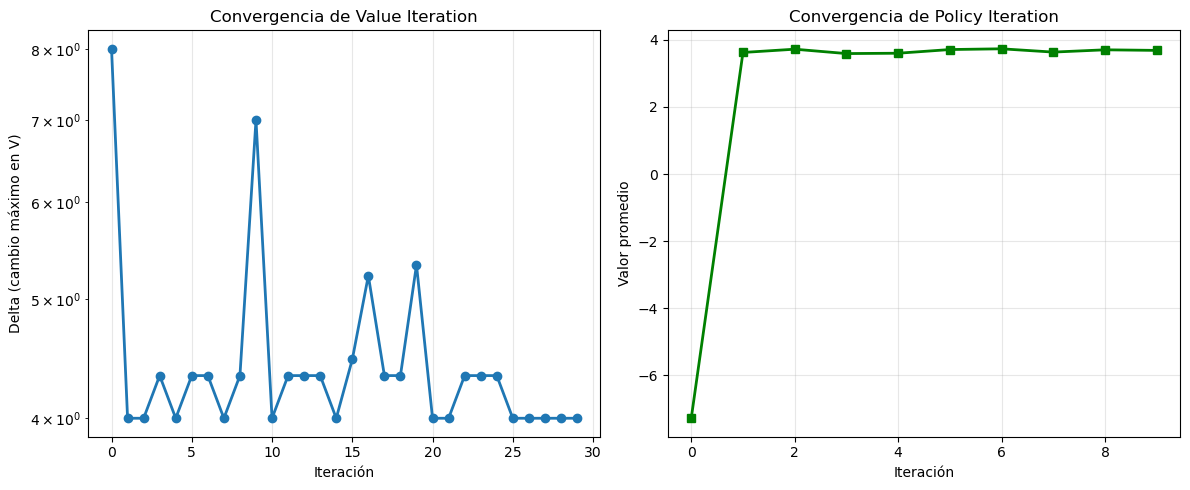


✓ Value Iteration convergió en 30 iteraciones
✓ Policy Iteration convergió en 10 iteraciones


In [20]:
plt.figure(figsize=(12, 5))

# Gráfica de convergencia de Value Iteration
plt.subplot(1, 2, 1)
plt.plot(history_vi, marker='o', linewidth=2)
plt.xlabel('Iteración')
plt.ylabel('Delta (cambio máximo en V)')
plt.title('Convergencia de Value Iteration')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Gráfica de convergencia de Policy Iteration
plt.subplot(1, 2, 2)
plt.plot(history_pi, marker='s', linewidth=2, color='green')
plt.xlabel('Iteración')
plt.ylabel('Valor promedio')
plt.title('Convergencia de Policy Iteration')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Value Iteration convergió en {len(history_vi)} iteraciones")
print(f"✓ Policy Iteration convergió en {len(history_pi)} iteraciones")

### 6.2 Comparación de Rendimiento entre Políticas

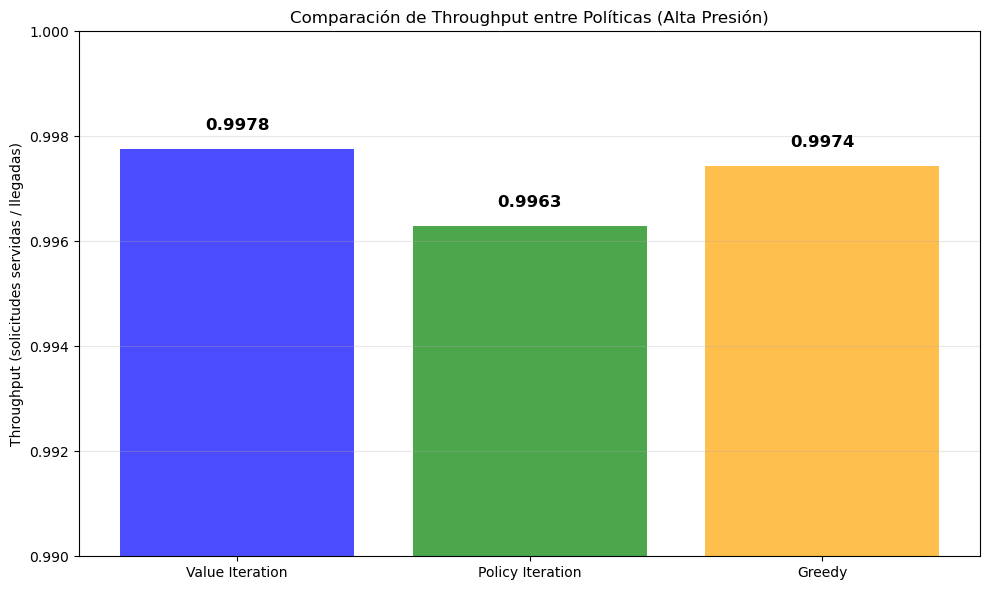

In [ ]:
# Comparación de throughput con eje ajustado para ver diferencias
plt.figure(figsize=(10, 6))

policies = ['Value Iteration', 'Policy Iteration', 'Greedy']
throughputs = [metrics_vi['throughput'], metrics_pi['throughput'], metrics_greedy['throughput']]
colors = ['blue', 'green', 'orange']

bars = plt.bar(policies, throughputs, color=colors, alpha=0.7)
plt.ylabel('Throughput (solicitudes servidas / llegadas)')
plt.title('Comparación de Throughput entre Políticas (Alta Presión)')
plt.ylim(0.990, 1.0)  
plt.grid(axis='y', alpha=0.3)


for bar, value in zip(bars, throughputs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.0003,
             f'{value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 6.3 Comparación de Múltiples Métricas

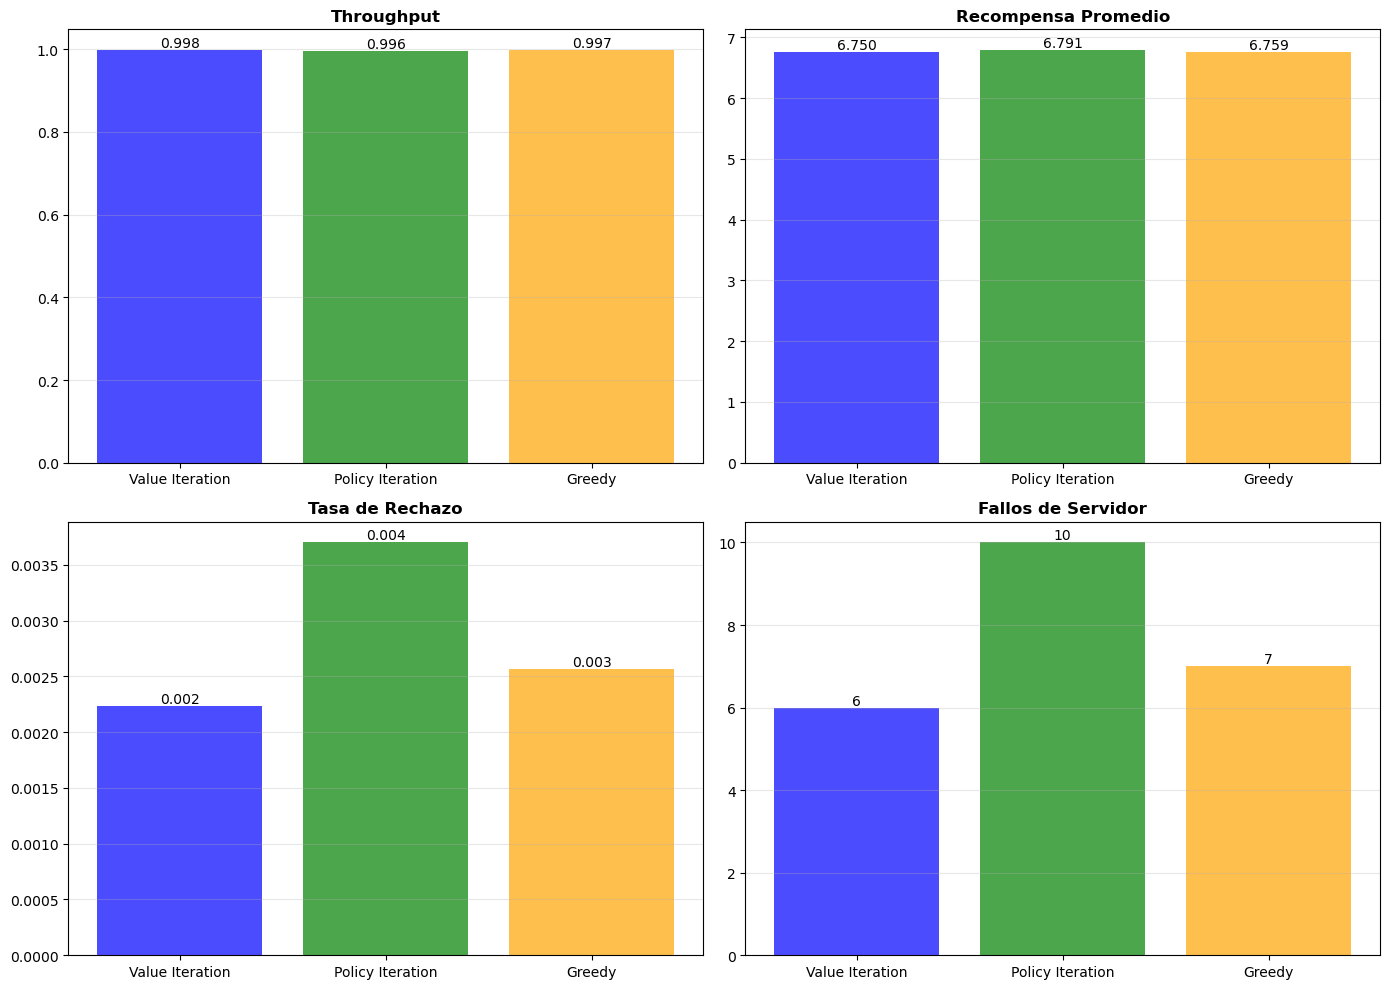

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics_names = ['throughput', 'avg_reward', 'rejection_rate', 'server_failures']
titles = ['Throughput', 'Recompensa Promedio', 'Tasa de Rechazo', 'Fallos de Servidor']

for idx, (metric, title) in enumerate(zip(metrics_names, titles)):
    ax = axes[idx // 3, idx % 3]
    
    values = [metrics_vi[metric], metrics_pi[metric], metrics_greedy[metric]]
    bars = ax.bar(policies, values, color=colors, alpha=0.7)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Ajustar eje Y para throughput
    if metric == 'throughput':
        ax.set_ylim(0.990, 1.0)
    
    # Añadir valores
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}' if isinstance(value, float) else f'{value}',
                ha='center', va='bottom', fontsize=10)

# Gráfica 5: Mejoras porcentuales respecto a Greedy
ax5 = axes[1, 1]
metrics_to_compare = ['Throughput', 'Recompensa']
vi_improvements = [
    ((metrics_vi['throughput'] - metrics_greedy['throughput']) / metrics_greedy['throughput']) * 100,
    ((metrics_vi['avg_reward'] - metrics_greedy['avg_reward']) / abs(metrics_greedy['avg_reward'])) * 100
]
pi_improvements = [
    ((metrics_pi['throughput'] - metrics_greedy['throughput']) / metrics_greedy['throughput']) * 100,
    ((metrics_pi['avg_reward'] - metrics_greedy['avg_reward']) / abs(metrics_greedy['avg_reward'])) * 100
]

x = np.arange(len(metrics_to_compare))
width = 0.35

bars1 = ax5.bar(x - width/2, vi_improvements, width, label='Value Iteration', color='blue', alpha=0.7)
bars2 = ax5.bar(x + width/2, pi_improvements, width, label='Policy Iteration', color='green', alpha=0.7)

ax5.set_ylabel('Mejora (%)')
ax5.set_title('Mejoras vs Greedy', fontsize=12, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(metrics_to_compare)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)
ax5.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Añadir valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+.2f}%', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

# Gráfica 6: Distribución de acciones
ax6 = axes[1, 2]

# Contar acciones de asignación por servidor
vi_server_assignments = [0] * N_SERVERS
pi_server_assignments = [0] * N_SERVERS
greedy_server_assignments = [0] * N_SERVERS

for action, count in metrics_vi['action_distribution'].items():
    if 0 <= action < N_SERVERS:
        vi_server_assignments[action] = count

for action, count in metrics_pi['action_distribution'].items():
    if 0 <= action < N_SERVERS:
        pi_server_assignments[action] = count

for action, count in metrics_greedy['action_distribution'].items():
    if 0 <= action < N_SERVERS:
        greedy_server_assignments[action] = count

# Normalizar a porcentajes
vi_total = sum(vi_server_assignments)
pi_total = sum(pi_server_assignments)
greedy_total = sum(greedy_server_assignments)

vi_pct = [100*x/vi_total for x in vi_server_assignments] if vi_total > 0 else vi_server_assignments
pi_pct = [100*x/pi_total for x in pi_server_assignments] if pi_total > 0 else pi_server_assignments
greedy_pct = [100*x/greedy_total for x in greedy_server_assignments] if greedy_total > 0 else greedy_server_assignments

x = np.arange(N_SERVERS)
width = 0.25

ax6.bar(x - width, vi_pct, width, label='Value Iteration', color='blue', alpha=0.7)
ax6.bar(x, pi_pct, width, label='Policy Iteration', color='green', alpha=0.7)
ax6.bar(x + width, greedy_pct, width, label='Greedy', color='orange', alpha=0.7)

ax6.set_xlabel('Servidor')
ax6.set_ylabel('% de asignaciones')
ax6.set_title('Distribución de Carga por Servidor', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels([f'S{i}' for i in range(N_SERVERS)])
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Distribución de carga:")
print(f"  Value Iteration: {[f'{p:.1f}%' for p in vi_pct]}")
print(f"  Policy Iteration: {[f'{p:.1f}%' for p in pi_pct]}")
print(f"  Greedy: {[f'{p:.1f}%' for p in greedy_pct]}")

## 7. Análisis de Políticas Óptimas

Analizamos las acciones más frecuentes en las políticas aprendidas.

In [23]:
def analyze_policy(policy, name="Policy"):
    """Analiza las acciones de una política."""
    print(f"\n=== Análisis de {name} ===")
    
    action_counts = defaultdict(int)
    for action in policy.values():
        action_counts[action] += 1
    
    total = sum(action_counts.values())
    print(f"Total de estados en política: {total}")
    print("\nDistribución de acciones:")
    
    # Ordenar por frecuencia
    sorted_actions = sorted(action_counts.items(), key=lambda x: x[1], reverse=True)
    
    for action, count in sorted_actions[:10]:  # Top 10 acciones
        percentage = 100 * count / total
        print(f"  {get_action_name(action)}: {count} ({percentage:.1f}%)")

analyze_policy(policy_vi, "Value Iteration")
analyze_policy(policy_pi, "Policy Iteration")


=== Análisis de Value Iteration ===
Total de estados en política: 1000

Distribución de acciones:
  Balancear carga: 165 (16.5%)
  Asignar a servidor 0: 165 (16.5%)
  Asignar a servidor 2: 164 (16.4%)
  Asignar a servidor 4: 152 (15.2%)
  Asignar a servidor 1: 147 (14.7%)
  Asignar a servidor 3: 143 (14.3%)
  Mantenimiento servidor 1: 16 (1.6%)
  Mantenimiento servidor 2: 16 (1.6%)
  Mantenimiento servidor 0: 15 (1.5%)
  Mantenimiento servidor 3: 11 (1.1%)

=== Análisis de Policy Iteration ===
Total de estados en política: 1000

Distribución de acciones:
  Asignar a servidor 0: 172 (17.2%)
  Balancear carga: 167 (16.7%)
  Asignar a servidor 1: 158 (15.8%)
  Asignar a servidor 4: 156 (15.6%)
  Asignar a servidor 2: 147 (14.7%)
  Asignar a servidor 3: 139 (13.9%)
  Mantenimiento servidor 2: 15 (1.5%)
  Mantenimiento servidor 1: 13 (1.3%)
  Mantenimiento servidor 4: 12 (1.2%)
  Mantenimiento servidor 3: 11 (1.1%)
